<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 - Ames Housing Data and Kaggle Challenge

## Problem Statement

There are are many variables that determine how much a home can fetch.
Using the Ames (IA) dataset (train, test), we want to find out which variables matter for home sale prices and produce accurate sale price predictions. 
This model will help provide the Outside View*, helping to reduce information asymmetry between potential home-buyers, home-sellers and real estate agents, and the success of the model will depend on the accuracy on how well the model is able to predict home prices.

### Contents

* Background
* Data sets used
* Data Import
* Cleaning Train Dataset

### Background 

The original original intent for the data was to be used for tax assessment purposes but lends itself directly to the prediction of home selling prices. The type of information contained in the data is similar to what a typical home buyer would want to know before making a purchase, like size, neighborhood, exterior, basement, sale price, etc.

### Data sets used 

* train.csv
* test.csv

### Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.utils import resample
from scipy import stats

In [2]:
train_df = pd.read_csv('./datasets/train.csv')
test_df = pd.read_csv('./datasets/test.csv')

# backup df
old_train_df = train_df
old_test_df = test_df

In [3]:
print(train_df.shape)
print(test_df.shape)

(2051, 81)
(878, 80)


In [4]:
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
test_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

###### Rename Columns

In [7]:
train_df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [8]:
# edit column names -> lower case -> replace space with _

train_df.columns= train_df.columns.str.lower()
train_df.columns = train_df.columns.str.replace(' ','_')

test_df.columns = test_df.columns.str.lower()
test_df.columns = test_df.columns.str.replace(' ','_')

In [9]:
# convert year to age train_df

train_df['house_age'] = train_df['yr_sold'] - train_df['year_built']
train_df['reno_age'] = train_df['yr_sold'] - train_df['year_remod/add']
train_df['garage_age'] = train_df['yr_sold'] - train_df['garage_yr_blt']

train_df.drop(columns=['year_built', 'year_remod/add', 'garage_yr_blt'],inplace = True)

In [10]:
#convert year to age test_df

test_df['house_age'] = test_df['yr_sold'] - test_df['year_built']
test_df['reno_age'] = test_df['yr_sold'] - test_df['year_remod/add']
test_df['garage_age'] = test_df['yr_sold'] - test_df['garage_yr_blt']

test_df.drop(columns=['year_built', 'year_remod/add', 'garage_yr_blt'],inplace = True)

In [11]:
test_df['lot_frontage'].isnull().sum()

160

In [12]:
test_df['garage_age'].isnull().sum()

45

### Cleaning Train Dataset

###### Dropping features with high percentage of NaNs 

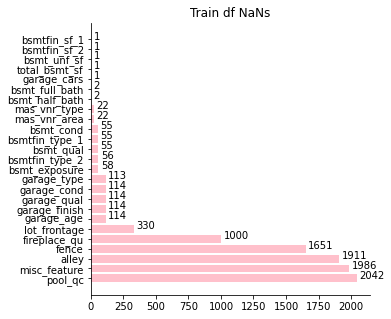

In [13]:
y = train_df.isnull().sum().sort_values(ascending = False).index[0:25]
width = train_df.isnull().sum().sort_values(ascending = False).values[0:25]
fig, ax = plt.subplots(figsize=(5,5))
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.barh(y, width,color='pink')
plt.title("Train df NaNs")
for index, value in enumerate(width):
    plt.text(value + 20, index,
             str(value))
  
plt.show()

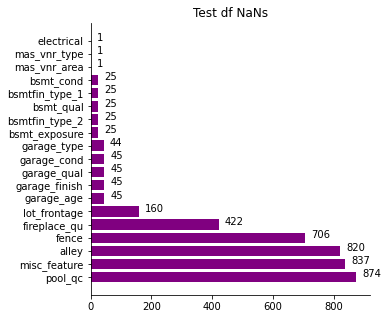

In [14]:
y = test_df.isnull().sum().sort_values(ascending = False).index[0:19]
width = test_df.isnull().sum().sort_values(ascending = False).values[0:19]
fig, ax = plt.subplots(figsize=(5,5))
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.barh(y, width,color='purple')
plt.title("Test df NaNs")
for index, value in enumerate(width):
    plt.text(value + 20, index,
             str(value))
  
plt.show()

Features like pool_qc, misc_feature, alley, fence, fireplace_qu have a high number of NaNs.

In [15]:
# % NaNs for pool_qc

874/2051

0.42613359336908824

In [16]:
# % NaNs for fireplace_qu

422 / 2051

0.20575329107752316

In [17]:
train_df.drop(columns = ['pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu'], inplace = True)
test_df.drop(columns = ['pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu'], inplace = True)

Dropping these 5 columns as they have a high % NaNs. Not only does a high % of NaN not feed the model any relavent info, it may even introduce noise affecting the accuracy.<br>
Furthermore, comparing the baseline RMSE scores for dropping and replacing with the mean, dropping them gave a better RMSE score of 

###### Ordinal Features

From data dictionary, we can see that some features are ordinal in nature. Convert these features to ordinal numbers to better represent the scale of the feature.

In [18]:
ordinal_features = ['exter_qual', 'exter_cond', 'bsmt_qual', 'bsmt_cond', 'kitchen_qual', 'garage_qual',
           'garage_cond', 'heating_qc']

In [19]:
# convert to ordinal features

# train_df

for x in ordinal_features:
    train_df[x].fillna(0, inplace=True)
    train_df[x].replace('Po', 1, inplace=True)
    train_df[x].replace('Fa', 2, inplace=True)
    train_df[x].replace('TA', 3, inplace=True)
    train_df[x].replace('Gd', 4, inplace=True)
    train_df[x].replace('Ex', 5, inplace=True)
    
# test_df

for x in ordinal_features:
    test_df[x].fillna(0, inplace=True)
    test_df[x].replace('Po', 1, inplace=True)
    test_df[x].replace('Fa', 2, inplace=True)
    test_df[x].replace('TA', 3, inplace=True)
    test_df[x].replace('Gd', 4, inplace=True)
    test_df[x].replace('Ex', 5, inplace=True)

###### Impute Numerical NaN values

In [20]:
train_df_num = train_df.select_dtypes(include=np.number).columns.tolist()

In [21]:
train_df_num

['id',
 'pid',
 'ms_subclass',
 'lot_frontage',
 'lot_area',
 'overall_qual',
 'overall_cond',
 'mas_vnr_area',
 'exter_qual',
 'exter_cond',
 'bsmt_qual',
 'bsmt_cond',
 'bsmtfin_sf_1',
 'bsmtfin_sf_2',
 'bsmt_unf_sf',
 'total_bsmt_sf',
 'heating_qc',
 '1st_flr_sf',
 '2nd_flr_sf',
 'low_qual_fin_sf',
 'gr_liv_area',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'kitchen_qual',
 'totrms_abvgrd',
 'fireplaces',
 'garage_cars',
 'garage_area',
 'garage_qual',
 'garage_cond',
 'wood_deck_sf',
 'open_porch_sf',
 'enclosed_porch',
 '3ssn_porch',
 'screen_porch',
 'pool_area',
 'misc_val',
 'mo_sold',
 'yr_sold',
 'saleprice',
 'house_age',
 'reno_age',
 'garage_age']

In [22]:
train_df[train_df_num].isnull().sum().sort_values(ascending=False)

lot_frontage       330
garage_age         114
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
bsmtfin_sf_1         1
garage_cars          1
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
screen_porch         0
pool_area            0
totrms_abvgrd        0
misc_val             0
mo_sold              0
3ssn_porch           0
enclosed_porch       0
open_porch_sf        0
wood_deck_sf         0
garage_cond          0
yr_sold              0
saleprice            0
garage_qual          0
house_age            0
reno_age             0
fireplaces           0
id                   0
kitchen_qual         0
bsmt_cond            0
ms_subclass          0
lot_area             0
overall_qual         0
overall_cond         0
exter_qual           0
exter_cond           0
bsmt_qual            0
heating_qc           0
kitchen_abvgr        0
1st_flr_sf           0
2nd_flr_sf           0
low_qual_fin_sf      0
gr_liv_area          0
pid        

Lot Frontage


Lot Frontage NaN % is relatively high and it seems to be missing completely at random. <br>

According to this [website](https://www.gimme-shelter.com/frontage-50043/), all houses have a lot frontage. It is the width of the lot.<br>

Opt to impute with mean as both values for both data sets are not far off.<br>

In [23]:
print('NaNs: ', train_df['lot_frontage'].isnull().sum())
print('Total: ', train_df.shape[0])
print('Percentage: ', (train_df['lot_frontage'].isnull().sum()/train_df.shape[0])*100)

NaNs:  330
Total:  2051
Percentage:  16.089712335446123


In [24]:
print(train_df['lot_frontage'].mean())
print(train_df['lot_frontage'].median())

69.05520046484602
68.0


In [25]:
print(test_df['lot_frontage'].mean())
print(test_df['lot_frontage'].median())

69.54596100278552
68.0


In [26]:
# As the median and the mean for lot_frontage is about the same, fill lot_frontage nan with lot_frontage mean

train_df['lot_frontage'].fillna(train_df['lot_frontage'].mean(),inplace=True)

# imputing test_df does not affect kaggle score

test_df['lot_frontage'].fillna(test_df['lot_frontage'].mean(),inplace=True)

Garage Age

Similar to lot frontage, garage_age NaN % is relatively high. <br>
By replacing all NaN with 0 means that the garage is relatively new, and by domain knowledge means that the price of the house will increase, which is untrue as NaN means that the house does not have a garage, which will actually bring down the price. Opt to impute with mean.

In [27]:
print('NaNs: ', train_df['garage_age'].isnull().sum())
print('Total: ', train_df.shape[0])
print('Percentage: ', (train_df['garage_age'].isnull().sum()/train_df.shape[0])*100)

NaNs:  114
Total:  2051
Percentage:  5.558264261335934


In [28]:
print(train_df['garage_age'].mean())
print(train_df['garage_age'].median())
print(test_df['garage_age'].mean())
print(test_df['garage_age'].median())

29.070211667527104
28.0
31.04921968787515
30.0


In [29]:
# # fill garage_age nan with garage_age mean

# train_df['garage_age'].fillna(train_df['garage_age'].mean(),inplace=True)

# test_df['garage_age'].fillna(test_df['garage_age'].mean(),inplace=True)

In [30]:
# Replace remaining numerical feature NaNs with 0, as they are only a small percentage of the data.

In [31]:
# drop garage_age

train_df.drop(columns = 'garage_age', inplace = True)

test_df.drop(columns = 'garage_age', inplace = True)

In [32]:
# replace NaN with 0

train_num_list = train_df.select_dtypes(exclude='object').columns.tolist()

for feature in train_num_list:
    train_df[feature].fillna(0, inplace = True)

In [33]:
train_df[train_num_list].isnull().sum().sort_values(ascending=False)

id                 0
wood_deck_sf       0
bedroom_abvgr      0
kitchen_abvgr      0
kitchen_qual       0
totrms_abvgrd      0
fireplaces         0
garage_cars        0
garage_area        0
garage_qual        0
garage_cond        0
open_porch_sf      0
pid                0
enclosed_porch     0
3ssn_porch         0
screen_porch       0
pool_area          0
misc_val           0
mo_sold            0
yr_sold            0
saleprice          0
house_age          0
half_bath          0
full_bath          0
bsmt_half_bath     0
bsmt_full_bath     0
ms_subclass        0
lot_frontage       0
lot_area           0
overall_qual       0
overall_cond       0
mas_vnr_area       0
exter_qual         0
exter_cond         0
bsmt_qual          0
bsmt_cond          0
bsmtfin_sf_1       0
bsmtfin_sf_2       0
bsmt_unf_sf        0
total_bsmt_sf      0
heating_qc         0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
reno_age           0
dtype: int64

##### Impute NaN values for train dataset categorical

In [34]:
train_cat_list = train_df.select_dtypes(include='object').columns.tolist()

train_df[train_cat_list].isnull().sum().sort_values(ascending=False)

garage_finish     114
garage_type       113
bsmt_exposure      58
bsmtfin_type_2     56
bsmtfin_type_1     55
mas_vnr_type       22
ms_zoning           0
exterior_2nd        0
paved_drive         0
functional          0
electrical          0
central_air         0
heating             0
foundation          0
exterior_1st        0
street              0
roof_matl           0
roof_style          0
house_style         0
bldg_type           0
condition_2         0
condition_1         0
neighborhood        0
land_slope          0
lot_config          0
utilities           0
land_contour        0
lot_shape           0
sale_type           0
dtype: int64

For the catagorical features with NaN, they represent that the feature simply does not exist in the home. Replace all NaN with None.

In [35]:
for feature in train_cat_list:
    train_df[feature].fillna('None', inplace = True)

In [36]:
train_df[train_cat_list].isnull().sum().sort_values(ascending=False)

ms_zoning         0
exterior_2nd      0
paved_drive       0
garage_finish     0
garage_type       0
functional        0
electrical        0
central_air       0
heating           0
bsmtfin_type_2    0
bsmtfin_type_1    0
bsmt_exposure     0
foundation        0
mas_vnr_type      0
exterior_1st      0
street            0
roof_matl         0
roof_style        0
house_style       0
bldg_type         0
condition_2       0
condition_1       0
neighborhood      0
land_slope        0
lot_config        0
utilities         0
land_contour      0
lot_shape         0
sale_type         0
dtype: int64

### Exploratory Data Analysis

###### Exploring Pearson's Correlation for each feature.

In [37]:
corr = train_df.corr()
corr['saleprice'].sort_values(ascending = False)

saleprice          1.000000
overall_qual       0.800207
exter_qual         0.712146
gr_liv_area        0.697038
kitchen_qual       0.692336
garage_area        0.649897
garage_cars        0.647781
total_bsmt_sf      0.629303
1st_flr_sf         0.618486
bsmt_qual          0.612188
full_bath          0.537969
totrms_abvgrd      0.504014
mas_vnr_area       0.503579
fireplaces         0.471093
heating_qc         0.458354
bsmtfin_sf_1       0.423856
open_porch_sf      0.333476
wood_deck_sf       0.326490
lot_frontage       0.325850
lot_area           0.296566
garage_qual        0.285281
bsmt_full_bath     0.283332
half_bath          0.283001
garage_cond        0.265021
2nd_flr_sf         0.248452
bsmt_cond          0.225075
bsmt_unf_sf        0.190861
bedroom_abvgr      0.137067
screen_porch       0.134581
3ssn_porch         0.048732
exter_cond         0.036418
mo_sold            0.032735
pool_area          0.023106
bsmtfin_sf_2       0.016432
misc_val          -0.007375
yr_sold           -0

There is a large number of features in the dataset, and some features may predict the target variable better than others. Dropping features that do not have a strong positive or negative Pearson's correlation with the target variable to reduce noise.

In [38]:
corr['saleprice'].sort_values(ascending = False).index

Index(['saleprice', 'overall_qual', 'exter_qual', 'gr_liv_area',
       'kitchen_qual', 'garage_area', 'garage_cars', 'total_bsmt_sf',
       '1st_flr_sf', 'bsmt_qual', 'full_bath', 'totrms_abvgrd', 'mas_vnr_area',
       'fireplaces', 'heating_qc', 'bsmtfin_sf_1', 'open_porch_sf',
       'wood_deck_sf', 'lot_frontage', 'lot_area', 'garage_qual',
       'bsmt_full_bath', 'half_bath', 'garage_cond', '2nd_flr_sf', 'bsmt_cond',
       'bsmt_unf_sf', 'bedroom_abvgr', 'screen_porch', '3ssn_porch',
       'exter_cond', 'mo_sold', 'pool_area', 'bsmtfin_sf_2', 'misc_val',
       'yr_sold', 'low_qual_fin_sf', 'bsmt_half_bath', 'id', 'ms_subclass',
       'overall_cond', 'kitchen_abvgr', 'enclosed_porch', 'pid', 'reno_age',
       'house_age'],
      dtype='object')

In [39]:
# 0.2

train_df.drop(columns = ['bsmt_unf_sf', 'bedroom_abvgr',
       'screen_porch', '3ssn_porch', 'exter_cond', 'mo_sold', 'pool_area', 'bsmtfin_sf_2', 'misc_val', 'yr_sold', 'low_qual_fin_sf',
       'bsmt_half_bath', 'ms_subclass', 'overall_cond', 'kitchen_abvgr',
       'enclosed_porch'], inplace = True)

In [40]:
# # 0.3

# train_df.drop(columns = ['lot_area',
#        'garage_qual', 'bsmt_full_bath', 'half_bath', 'garage_cond',
#        '2nd_flr_sf', 'bsmt_cond', 'bsmt_unf_sf', 'bedroom_abvgr',
#        'screen_porch', '3ssn_porch', 'exter_cond', 'mo_sold',
#        'pool_area', 'bsmtfin_sf_2', 'misc_val', 'yr_sold', 'low_qual_fin_sf',
#        'bsmt_half_bath', 'ms_subclass', 'overall_cond', 'kitchen_abvgr',
#        'enclosed_porch', 'pid'], inplace = True)

In [41]:
train_df.shape

(2051, 59)

###### Plotting each numerical feature against target variable to check for any irregularities or outliers.

In [42]:
# for feature in train_df.select_dtypes(exclude='object').columns.tolist():
#     plt.figure(figsize= ( 10, 5 ))
#     sns.scatterplot(data=train_df, x=feature, y='saleprice')
#     plt.show()

In [43]:
# remove outliers

train_df = train_df[(train_df['lot_frontage'] <=300)]
train_df = train_df[(train_df['mas_vnr_area'] <=1400)]
train_df = train_df[(train_df['bsmtfin_sf_1'] <=3000)]
train_df = train_df[(train_df['total_bsmt_sf'] <=4000)]
train_df = train_df[(train_df['1st_flr_sf'] <=3000)]
train_df = train_df[(train_df['gr_liv_area'] <=4000)]
train_df = train_df[(train_df['wood_deck_sf'] <=1000)]

###### Plotting histograms to see the distribution of each numerical feature.

In [44]:
# for feature in train_df.select_dtypes(exclude='object').columns.tolist():
#     plt.figure(figsize= ( 10, 5 ))
#     sns.histplot(data=train_df, x=feature, bins = 50, kde = True)
#     plt.show()

Histogram to see if the features are distributed normally. There are some features including our target variable that are right skewed.

###### Plotting box graphs to see if there is any relationships between each catagorical feature with our target variable.

In [45]:
# for feature in train_df.select_dtypes(include='object').columns.tolist():
#     sns.boxplot(data=train_df, x=feature, y='saleprice')
#     plt.show()

Boxplots to see the relation of each catagorical feature with the saleprice. We can see that some features like ms_zoning, neighborhood, condition_1, condition_2, exterior_1st, exterior_2nd, garage_type and sale_type has some relation with saleprice.

### Cleaning Test Dataset

###### Impute NaN values

Matching test dataframe colums with train dataframe columns. This will remove the same poorly correlated features from test dataset.

In [46]:
test_df.shape

(878, 74)

In [47]:
test_df.isnull().sum().sort_values(ascending = False)

garage_finish     45
garage_type       44
bsmtfin_type_1    25
bsmt_exposure     25
bsmtfin_type_2    25
                  ..
bsmtfin_sf_2       0
bsmt_unf_sf        0
total_bsmt_sf      0
pid                0
reno_age           0
Length: 74, dtype: int64

In [48]:
temp_list = train_df.columns.tolist()

In [49]:
temp_list.remove('saleprice')

In [50]:
test_df = test_df[temp_list]

In [51]:
test_df.shape

(878, 58)

##### Impute NaN values for test dataset numerical.

In [52]:
test_df_num = test_df.select_dtypes(exclude='object').columns.tolist()

In [53]:
test_df[test_df_num].isnull().sum().sort_values(ascending=False)

mas_vnr_area      1
id                0
bsmt_full_bath    0
house_age         0
open_porch_sf     0
wood_deck_sf      0
garage_cond       0
garage_qual       0
garage_area       0
garage_cars       0
fireplaces        0
totrms_abvgrd     0
kitchen_qual      0
half_bath         0
full_bath         0
gr_liv_area       0
pid               0
2nd_flr_sf        0
1st_flr_sf        0
heating_qc        0
total_bsmt_sf     0
bsmtfin_sf_1      0
bsmt_cond         0
bsmt_qual         0
exter_qual        0
overall_qual      0
lot_area          0
lot_frontage      0
reno_age          0
dtype: int64

In [54]:
for feature in test_df_num:
    test_df[feature].fillna(0, inplace = True)

C:\Users\Darre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Replace all NaNs with 0.

##### Impute NaN values for test dataset numerical categorical

In [55]:
test_df.isnull().sum().sort_values(ascending = False)

garage_finish     45
garage_type       44
bsmtfin_type_2    25
bsmtfin_type_1    25
bsmt_exposure     25
electrical         1
mas_vnr_type       1
half_bath          0
heating            0
heating_qc         0
central_air        0
1st_flr_sf         0
2nd_flr_sf         0
gr_liv_area        0
bsmt_full_bath     0
full_bath          0
id                 0
kitchen_qual       0
total_bsmt_sf      0
functional         0
fireplaces         0
garage_cars        0
garage_area        0
garage_qual        0
garage_cond        0
paved_drive        0
wood_deck_sf       0
open_porch_sf      0
sale_type          0
house_age          0
totrms_abvgrd      0
bsmtfin_sf_1       0
pid                0
bsmt_cond          0
ms_zoning          0
lot_frontage       0
lot_area           0
street             0
lot_shape          0
land_contour       0
utilities          0
lot_config         0
land_slope         0
neighborhood       0
condition_1        0
condition_2        0
bldg_type          0
house_style  

In [56]:
test_df_cat = test_df.select_dtypes(include='object').columns.tolist()

In [57]:
test_df[test_df_cat].isnull().sum().sort_values(ascending = False)

garage_finish     45
garage_type       44
bsmtfin_type_2    25
bsmtfin_type_1    25
bsmt_exposure     25
electrical         1
mas_vnr_type       1
ms_zoning          0
exterior_2nd       0
paved_drive        0
functional         0
central_air        0
heating            0
foundation         0
exterior_1st       0
street             0
roof_matl          0
roof_style         0
house_style        0
bldg_type          0
condition_2        0
condition_1        0
neighborhood       0
land_slope         0
lot_config         0
utilities          0
land_contour       0
lot_shape          0
sale_type          0
dtype: int64

In [58]:
test_df['electrical'].unique()

array(['FuseP', 'SBrkr', 'FuseA', 'FuseF', nan], dtype=object)

In [59]:
test_df['electrical'].fillna('SBrkr', inplace = True)

Impute test_df electrical with mode 'SBrkr'.

In [60]:
test_df.isnull().sum().sort_values(ascending = False)
test_df_cat = test_df.select_dtypes(include='object').columns.tolist()

In [61]:
for feature in test_df_cat:
    test_df[feature].fillna('None', inplace = True)

In [62]:
test_df.shape

(878, 58)

Replace NaNs with 'None'

### Get Dummies

Dummify categorical features for both train and test datasets.

In [63]:
train_df_cat = train_df.select_dtypes(include='object').columns.tolist()

In [64]:
train_df = pd.get_dummies(data=train_df,columns=train_df_cat)

In [65]:
test_df_cat = test_df.select_dtypes(include='object').columns.tolist()

In [66]:
test_df = pd.get_dummies(data=test_df, columns=test_df_cat)

In [67]:
train_df.shape

(2044, 229)

In [68]:
test_df.shape

(878, 217)

There are different columns in dummified train and test df. Checking which columns each df does not have.

In [69]:
# declare list variable
train_df_missing_col = []
test_df_missing_col = []

# append column missing in train_df

for col in test_df.columns:
    if col not in train_df.columns:
        train_df_missing_col.append(col)
        
# append column missing in test_df

for col in train_df.columns:
    if col != 'saleprice':
        if col not in test_df.columns:
            test_df_missing_col.append(col)



In [70]:
train_df_missing_col # columns in test not in train

['roof_matl_Metal',
 'roof_matl_Roll',
 'exterior_1st_PreCast',
 'exterior_2nd_Other',
 'exterior_2nd_PreCast',
 'mas_vnr_type_CBlock',
 'heating_Floor',
 'sale_type_VWD']

In [71]:
test_df_missing_col # columns in train not in test

['ms_zoning_A (agr)',
 'utilities_NoSeWa',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'condition_2_Artery',
 'condition_2_PosN',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran',
 'exterior_1st_CBlock',
 'exterior_1st_ImStucc',
 'exterior_1st_Stone',
 'exterior_2nd_Stone',
 'heating_OthW',
 'heating_Wall',
 'electrical_Mix',
 'functional_Sal',
 'functional_Sev']

In [72]:
test_df[train_df_missing_col].sum()

roof_matl_Metal         1
roof_matl_Roll          1
exterior_1st_PreCast    1
exterior_2nd_Other      1
exterior_2nd_PreCast    1
mas_vnr_type_CBlock     1
heating_Floor           1
sale_type_VWD           1
dtype: int64

In [73]:
train_df[test_df_missing_col].sum()

ms_zoning_A (agr)       2
utilities_NoSeWa        1
neighborhood_GrnHill    2
neighborhood_Landmrk    1
condition_2_Artery      5
condition_2_PosN        3
condition_2_RRAe        1
condition_2_RRAn        1
condition_2_RRNn        2
roof_matl_Membran       1
exterior_1st_CBlock     2
exterior_1st_ImStucc    1
exterior_1st_Stone      2
exterior_2nd_Stone      6
heating_OthW            2
heating_Wall            6
electrical_Mix          1
functional_Sal          2
functional_Sev          2
dtype: int64

Opting to remove missing columns from each dataset.<br>
If columns were added, only a small percentage of meaningfull data will be added (ie 1/878 to 6/2043 $\approx$ 0.1% to 0.3%) and a large percentage of noise will be included.<br>

Removing colums in train dataset that does not exist in test dataset.

In [74]:
for col in train_df.columns:
    if col != 'saleprice':
        if col not in test_df.columns:
            print(col)
            train_df.drop(columns=col, inplace = True)

ms_zoning_A (agr)
utilities_NoSeWa
neighborhood_GrnHill
neighborhood_Landmrk
condition_2_Artery
condition_2_PosN
condition_2_RRAe
condition_2_RRAn
condition_2_RRNn
roof_matl_Membran
exterior_1st_CBlock
exterior_1st_ImStucc
exterior_1st_Stone
exterior_2nd_Stone
heating_OthW
heating_Wall
electrical_Mix
functional_Sal
functional_Sev


Removing colums in test dataset that does not exist in train dataset.

In [75]:
for col in test_df.columns:
    if col != 'saleprice':
        if col not in train_df.columns:
            print(col)
            test_df.drop(columns=col, inplace = True)

roof_matl_Metal
roof_matl_Roll
exterior_1st_PreCast
exterior_2nd_Other
exterior_2nd_PreCast
mas_vnr_type_CBlock
heating_Floor
sale_type_VWD


Only the saleprice column will be log transformed, as transforming the other features did not positively impact the model much

# Train and score model

In [76]:
X = train_df.drop(columns = 'saleprice')
y = train_df['saleprice']

In [77]:
print(X.shape)
y.shape

(2044, 209)


(2044,)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 147)

In [79]:
ss = StandardScaler()

In [80]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Baseline Model 

In [81]:
# baseline model

y_baseline_pred = [np.mean(train_df['saleprice']) for i in range(len(y_test))]
print(y_baseline_pred[:5])
print(len(y_baseline_pred))

[181245.99217221135, 181245.99217221135, 181245.99217221135, 181245.99217221135, 181245.99217221135]
675


In [82]:
# baseline rmse

baseline_rmse = mean_squared_error(y_test, y_baseline_pred, squared = False)
baseline_rmse

75248.15024215599

### Linear Regression

Linear Regression model will make a the best fit line to predict the sale price. It takes into account all features, wh

In [83]:
lr = LinearRegression()

In [84]:
lr.fit(X_train_sc, np.log(y_train))

LinearRegression()

In [85]:
lr_train_r2 = lr.score(X_train_sc, np.log(y_train))
lr_test_r2 = lr.score(X_test_sc, np.log(y_test))
lr_train_cv_r2 = cross_val_score(lr, X_train_sc, np.log(y_train), cv = 5).mean()
lr_test_cv_r2 = cross_val_score(lr, X_test_sc,  np.log(y_test), cv = 5).mean()

In [86]:
# by left way

lr_y_pred = lr.predict(X_test_sc)
lr_rmse = mean_squared_error(y_test, lr_y_pred, squared = False)
lr_rmse_train = mean_squared_error(y_train, lr.predict(X_train_sc),squared = False)

In [87]:
# # by right way

# lr_y_pred = np.exp(lr.predict(X_test_sc))
# lr_rmse = mean_squared_error(y_test, lr_y_pred, squared = False)
# lr_rmse_train = mean_squared_error(y_train, np.exp(lr.predict(X_train_sc)),squared = False)

### Linear Regression with Ridge

In [88]:
r_alphas = np.logspace (-1, 10, 300)

In [89]:
ridgecv = RidgeCV(r_alphas)

In [90]:
ridgecv.fit(X_train_sc, np.log(y_train))
ridgecv_r2_train = (ridgecv.score(X_train_sc, np.log(y_train)))
ridgecv_r2_test = (ridgecv.score(X_test_sc, np.log(y_test)))

In [91]:
r_y_pred = np.exp(ridgecv.predict(X_test_sc))

In [92]:
r_rmse = mean_squared_error(y_test,r_y_pred,squared=False)

In [93]:
r_rmse_train = mean_squared_error(y_train, np.exp(ridgecv.predict(X_train_sc)),squared = False)

### Linear Regression with Lasso

In [94]:
lassocv = LassoCV(n_alphas = 500)

In [95]:
lassocv.fit(X_train_sc, np.log(y_train))
lasso_train_r2 = lassocv.score(X_train_sc, np.log(y_train))
lasso_test_r2 = lassocv.score(X_test_sc, np.log(y_test))

In [96]:
l_y_pred = np.exp(lassocv.predict(X_test_sc))

In [97]:
l_rmse = mean_squared_error(y_test,l_y_pred,squared=False)

In [98]:
l_rmse_train = mean_squared_error(y_train, np.exp(lassocv.predict(X_train_sc)), squared = False)

In [99]:
def lasso_model():
    t = PrettyTable(['Model', 'R2 Scores', 'RMSE'])

    print(t)

In [100]:
from prettytable import PrettyTable
def model_scores():
    t = PrettyTable(['Model', 'R2 Scores', 'RMSE'])
    t.add_row(['Baseline', 'na', 'na'])
    t.add_row(['Baseline', 'na', baseline_rmse])
    t.add_row(['-------', '-------', '-------'])
    t.add_row(['Linear Regression Train', lr_train_r2, lr_rmse_train])
    t.add_row(['Linear Regression Train', lr_test_r2, lr_rmse])
    t.add_row(['-------', '-------', '-------'])
    t.add_row(['Ridge CV Train', ridgecv_r2_train, r_rmse_train])
    t.add_row(['Ridge CV Test', ridgecv_r2_test, r_rmse])
    t.add_row(['-------', '-------', '-------'])
    t.add_row(['Lasso Train CV', lasso_train_r2, l_rmse_train])
    t.add_row(['Lasso Test CV', lasso_test_r2, l_rmse])
    t.add_row(['-------', '-------', '-------'])
    print(t)

In [101]:
model_scores()

+-------------------------+-------------------------+--------------------+
|          Model          |        R2 Scores        |        RMSE        |
+-------------------------+-------------------------+--------------------+
|         Baseline        |            na           |         na         |
|         Baseline        |            na           | 75248.15024215599  |
|         -------         |         -------         |      -------       |
| Linear Regression Train |    0.9437008265024215   | 199527.17614721344 |
| Linear Regression Train | -2.8405279831539125e+23 | 207437241022.22318 |
|         -------         |         -------         |      -------       |
|      Ridge CV Train     |    0.9429650749185645   | 17994.83430639429  |
|      Ridge CV Test      |    0.8755757232186198   | 21705.75993537153  |
|         -------         |         -------         |      -------       |
|      Lasso Train CV     |    0.9414520842531235   | 18179.026718179277 |
|      Lasso Test CV     

Looking at the R2 scores for all 3 models, Linear Regression did the worse with a very large difference between the train and test score. The model looked overfit. It could be due to the large number of features that were made in the process. We will use this as our baseline model. Comparing lasso and ridge R2 scores, both models have very high R2 scores, meaning that a high percentage of the variance of our target value can be explained by our features with our models.

### Coefficients

In [102]:
lasso_coefs = pd.DataFrame(list(zip(np.exp(lassocv.coef_),X.columns)))
lasso_coefs.rename(columns = { 0:
                       'coef',
                       1:
                       'variable'}, inplace = True)
lasso_coefs.sort_values(by='coef', ascending = False, inplace = True)
lasso_coefs['coef'] = lasso_coefs['coef'] - 1

In [103]:
ridge_coefs = pd.DataFrame(list(zip(np.exp(ridgecv.coef_),X.columns)))
ridge_coefs.rename(columns = { 0:
                       'coef',
                       1:
                       'variable'}, inplace = True)
ridge_coefs.sort_values(by='coef', ascending = False, inplace = True)
ridge_coefs['coef'] = ridge_coefs['coef'] - 1

In [104]:
linear_coefs = pd.DataFrame(list(zip(np.exp(lr.coef_),X.columns)))
linear_coefs.rename(columns = { 0:
                       'coef',
                       1:
                       'variable'}, inplace = True)
linear_coefs.sort_values(by='coef', ascending = False, inplace = True)
linear_coefs['coef'] = linear_coefs['coef'] - 1

C:\Users\Darre\AppData\Local\Temp/ipykernel_14072/2007225375.py:1: RuntimeWarning: overflow encountered in exp
  linear_coefs = pd.DataFrame(list(zip(np.exp(lr.coef_),X.columns)))


In [105]:
# recap corr from above

corr['saleprice'].sort_values(ascending = False).head(10)

saleprice        1.000000
overall_qual     0.800207
exter_qual       0.712146
gr_liv_area      0.697038
kitchen_qual     0.692336
garage_area      0.649897
garage_cars      0.647781
total_bsmt_sf    0.629303
1st_flr_sf       0.618486
bsmt_qual        0.612188
Name: saleprice, dtype: float64

In [106]:
corr['saleprice'].sort_values(ascending = False).tail(10)

low_qual_fin_sf   -0.041594
bsmt_half_bath    -0.045290
id                -0.051398
ms_subclass       -0.087335
overall_cond      -0.097019
kitchen_abvgr     -0.125444
enclosed_porch    -0.135656
pid               -0.255052
reno_age          -0.551716
house_age         -0.571881
Name: saleprice, dtype: float64

In [107]:
linear_coefs.head()

,coef,variable
104,inf,house_style_SFoyer
109,inf,roof_style_Hip
137,inf,exterior_2nd_Plywood
136,inf,exterior_2nd_MetalSd
135,inf,exterior_2nd_ImStucc


In [108]:
linear_coefs.tail()

,coef,variable
85,-1.0,condition_1_PosN
84,-1.0,condition_1_PosA
83,-1.0,condition_1_Norm
45,-1.0,utilities_AllPub
160,-1.0,bsmtfin_type_1_LwQ


In [109]:
lasso_coefs.head(10)

,coef,variable
185,0.152997,functional_Typ
14,0.130339,gr_liv_area
4,0.090299,overall_qual
182,0.083784,functional_Min1
183,0.078952,functional_Min2
184,0.065065,functional_Mod
9,0.033875,bsmtfin_sf_1
192,0.029830,garage_type_None
180,0.027334,functional_Maj1
171,0.022970,heating_GasA


In [110]:
lasso_coefs.tail(10)

,coef,variable
62,-0.010363,neighborhood_Edwards
95,-0.010973,bldg_type_Duplex
131,-0.011849,exterior_2nd_BrkFace
116,-0.011996,exterior_1st_AsbShng
66,-0.013577,neighborhood_MeadowV
60,-0.013736,neighborhood_CollgCr
118,-0.015255,exterior_1st_BrkComm
27,-0.029669,house_age
29,-0.030847,ms_zoning_C (all)
28,-0.037422,reno_age


In [111]:
ridge_coefs.head(10)

,coef,variable
185,0.156459,functional_Typ
33,0.095163,ms_zoning_RL
182,0.086830,functional_Min1
4,0.085160,overall_qual
14,0.084264,gr_liv_area
183,0.081487,functional_Min2
184,0.066862,functional_Mod
34,0.060367,ms_zoning_RM
30,0.052389,ms_zoning_FV
12,0.045750,1st_flr_sf


In [112]:
ridge_coefs.tail(10)

,coef,variable
29,-0.016179,ms_zoning_C (all)
116,-0.016546,exterior_1st_AsbShng
118,-0.016683,exterior_1st_BrkComm
76,-0.018174,neighborhood_SawyerW
66,-0.020953,neighborhood_MeadowV
120,-0.021018,exterior_1st_CemntBd
62,-0.026950,neighborhood_Edwards
60,-0.031493,neighborhood_CollgCr
27,-0.031722,house_age
28,-0.036964,reno_age


Coefficients mean that for every unit increase for the feature, our target will also increase. <br>
<br>
For Linear Regression with Ridge and Lasso, the top 5 positive coefficients are similar, mainly consisting of
- gr_living_area ( above grade living area square feet )
- overall_qual ( overall material and finish quality )
- functional_typ ( home functionality rating: house with typical functionality )
- functional_min1 ( home functionality rating: house with minor deductions 1)
- functional_min2 ( home functionality rating : house with deductions 2)

The top 5 negative coefficients are simiar,
- reno_age ( number of years since last renovation )
- house_age ( age of the house )
- neighborhood ( College Creek )
- ms_zoning_c (  Identifies the general zoning classification of the sale: Commercial )
- exterior_1st_BrkComm ( exterior covering of house: brick common )


### Distribution of Residuals 

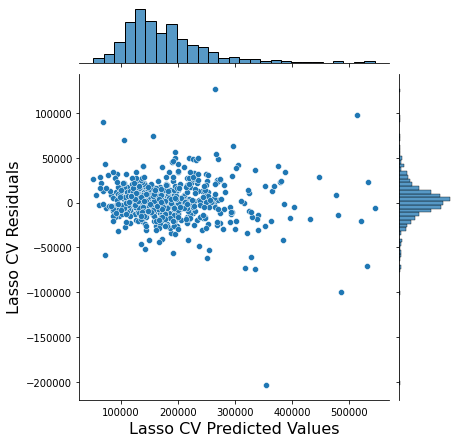

In [113]:
l_residuals = y_test - l_y_pred
lasso_joint = sns.jointplot(y=l_residuals,x=l_y_pred)
lasso_joint.set_axis_labels('Lasso CV Predicted Values', 'Lasso CV Residuals', fontsize=16);

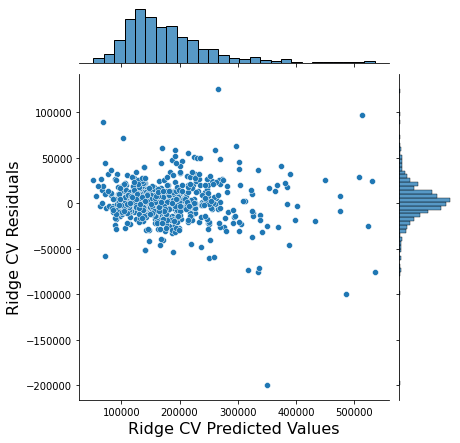

In [114]:
r_residuals = y_test - r_y_pred
ridge_joint = sns.jointplot(y=r_residuals,x=r_y_pred)
ridge_joint.set_axis_labels('Ridge CV Predicted Values', 'Ridge CV Residuals', fontsize=16);

The distribution of residuals for both lasso and ridge seem to be normally distributed, satisfying the condition of normally distributed for linear regression.

### Kaggle Submission Score

###### Linear Regression

In [115]:
X_sc = ss.fit_transform(X)
test_sc = ss.transform(test_df)

linear = LinearRegression()

linear.fit(X_sc, np.log(y))

chosen_y_pred = np.exp(linear.predict(test_sc))

submission_ridge = pd.DataFrame()
submission_ridge['Id'] = test_df['id']
submission_ridge['SalePrice'] = chosen_y_pred
submission_ridge.to_csv('./datasets/linear regression submission.csv', index = False)

C:\Users\Darre\AppData\Local\Temp/ipykernel_14072/2557273678.py:8: RuntimeWarning: overflow encountered in exp
  chosen_y_pred = np.exp(linear.predict(test_sc))


##### Linear Regression with Lasso Submission to Kaggle

In [116]:
lasso_chosen = lassocv.alpha_

X_sc = ss.fit_transform(X)
test_sc = ss.transform(test_df)

lasso = Lasso(alpha = lasso_chosen)

lasso.fit(X_sc, np.log(y))

print('R2 score:')
print(lasso.score(X_sc, np.log(y)))

chosen_l_y_pred = np.exp(lasso.predict(test_sc))

submission_ridge = pd.DataFrame()
submission_ridge['Id'] = test_df['id']
submission_ridge['SalePrice'] = chosen_l_y_pred
submission_ridge.to_csv('./datasets/lasso submission.csv', index = False)

R2 score:
0.9294166477655412


##### Linear Regression with Ridge Submission to Kaggle

In [117]:
ridge_chosen = ridgecv.alpha_

X_sc = ss.fit_transform(X)
test_sc = ss.transform(test_df)

ridge = Ridge(alpha = ridge_chosen)

ridge.fit(X_sc, np.log(y))

print('R2 score:')
print(ridge.score(X_sc, np.log(y)))

chosen_r_y_pred = np.exp(ridge.predict(test_sc))

submission_ridge = pd.DataFrame()
submission_ridge['Id'] = test_df['id']
submission_ridge['SalePrice'] = chosen_r_y_pred
submission_ridge.to_csv('./datasets/ridge submission.csv', index = False)

R2 score:
0.9312734561653201


### Lasso Kaggle score: <br>
Private: 19,763<br>
Public: 21,004<br>
It has a spread of 1241.<br><br>
Ridge Kaggle score:<br>
Private Score: 20040<br>
Public Score: 21,347<br>
It has a spread of 1307.

# Conclusion

###### Model Choice : Linear Regression with Lasso

Looking at the overall scoring for Linear Regression, it is not a good model for our situation as it is overfit.<br>
<br>
Using the train test scores for linear regression, we can see that for lasso and ridge, the training scores were a little lower. This is to be expected as we introduced some bias to get better accuracy, which can be seen in the test set R2 scores for lasso and ridge.<br>
<br>
Between Lasso and Ridge, both models gave good metrics, with a similar RMSE and coefficients. However, the best model for this case would be Linear Regression with Lasso, as it predicts the saleprice with the highest accuracy among the 3 models, and the lowst RMSE spread.<br><br>

###### Findings

Our model is able to predict sale price of a house, given it's features with an accuracy of +- $19,763 ( based on kaggle private score ). <br><br>
Features that affect the sale price positively are:<br>
- gr_living_area ( above grade living area square feet )
- overall_qual ( overall material and finish quality )
- functional_typ ( home functionality rating: house with typical functionality )
- functional_min1 ( home functionality rating: house with minor deductions 1)
- functional_min2 ( home functionality rating : house with deductions 2)<br><br>
Features that affect the sale price negatively are:<br>
- reno_age ( number of years since last renovation )
- house_age ( age of the house )
- neighborhood ( College Creek )
- ms_zoning_c (  Identifies the general zoning classification of the sale: Commercial )
- exterior_1st_BrkComm ( exterior covering of house: brick common )


With this in mind, home buyers / sellers and real estate agents are able to get an outside view of the market rate of a house. They can have a rough feel of the price of the house by observing the features that positively and negatively affect the price.<br>
They can also use the model to get a clearer picture of theh saleprice. In this way, they will not overpay / under price / estimate inaccurately the value of a house<br>
Buyers and real estate agents are able to pick out under priced house, and sellers know when they are offered a good price.